In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

from konlpy.tag import Kkma

kkma = Kkma()
np.random.seed(seed=0)

In [3]:
data = pd.read_csv("MBNnews2018.csv", nrows = 30000, encoding='CP949')
print('전체 뉴스 개수 :', (len(data)))

전체 뉴스 개수 : 30000


In [4]:
data.head()

,MBN_MDA_SP_CD,MDA_ART_ESSN_NO,MDA_CGR_NM,ART_DATE,ART_SJ_CN,ART_CN,ATCH_IMG_NM,JRNL_NM,WRT_DATE
0,MBN,3424432,mbn00003,2018,"11월 국제여객 전년비 11% 증가…""중국 노선 감소폭 완화""",지난해 11월 국제선 여객이 전년 동월 대비 11.1% 증가한 것으로 나타났습니다....,NaN,NaN,20180101
1,MBN,3424434,mbn00003,2018,"""고객을 웃게하자""...올 한해 행복 전파 나선 현대백화점<br />",<br /><!------------ PHOTO_POS_0 ------------>...,http://img.mbn.co.kr/filewww/news/other/2018/0...,NaN,20180101
2,MBN,3424435,mbn00003,2018,강남차병원 `새해 첫아기` 2명 탄생<br />,<br /><!------------ PHOTO_POS_0 ------------>...,http://img.mbn.co.kr/filewww/news/other/2018/0...,NaN,20180101
3,MBN,3424448,mbn00003,2018,지난해 수출 5천739억달러 '사상최대'…반도체 수출 첫 900억달러,<br /><br /><br /><br /><!------------ PHOTO_P...,NaN,NaN,20180101
4,MBN,3424511,mbn00003,2018,"중기부, 전통시장에 화재알림시설 설치<br />",<br /> 앞으로 5년내 전국 전통시장에 첨단 IT 기반의 화재알림시설이 설치된다...,NaN,NaN,20180101


In [5]:
data = data[['ART_SJ_CN', 'ART_CN']]
data.head()

,ART_SJ_CN,ART_CN
0,"11월 국제여객 전년비 11% 증가…""중국 노선 감소폭 완화""",지난해 11월 국제선 여객이 전년 동월 대비 11.1% 증가한 것으로 나타났습니다....
1,"""고객을 웃게하자""...올 한해 행복 전파 나선 현대백화점<br />",<br /><!------------ PHOTO_POS_0 ------------>...
2,강남차병원 `새해 첫아기` 2명 탄생<br />,<br /><!------------ PHOTO_POS_0 ------------>...
3,지난해 수출 5천739억달러 '사상최대'…반도체 수출 첫 900억달러,<br /><br /><br /><br /><!------------ PHOTO_P...
4,"중기부, 전통시장에 화재알림시설 설치<br />",<br /> 앞으로 5년내 전국 전통시장에 첨단 IT 기반의 화재알림시설이 설치된다...


In [6]:
data.sample(10)

,ART_SJ_CN,ART_CN
8225,법원 판결에…고용부vs삼성 '이례적 격돌',<!------------ PHOTO_POS_0 ------------>【 앵커멘트...
10794,혼다 어코드 등 수입차의 습격…국산차 업계 '긴장',<!------------ PHOTO_POS_0 ------------>【 앵커멘트...
9163,"LG, 서울 마곡에 사이언스파크 오픈…4차 산업혁명 미래기술 산실 기대",LG그룹이 조성한 국내 최대 규모 융복합 연구단지인 마곡 LG사이언스파크가 오늘(2...
26591,"이주열 총재, 미 금리인상 신중론에 ""두고 봐야""",<!------------ PHOTO_POS_0 ------------>이주열 한국...
6631,"르 메르디앙, 가족 휴식 패키지 '패밀리 릴렉세이션' 출시",르 메르디앙이 봄을 맞아 가족이 함께 여유로운 휴식을 즐길 수 있는 르 메르디앙 패...
14161,"이준행 고팍스 대표 ""투명성 강화…상장 수수료 안받는다""",【 앵커멘트 】<br /> 최근 잇따른 해킹·사기 의혹 등으로 홍역을 치른 암호화...
252,"[신년사] 정성립 대우조선 사장 ""창조적 파괴·시스템 구축으로 자존심 되찾자""<br />","<br />정성립 대우조선해양 사장은 4일 파괴와 창조를 통해 미래를 준비하고, 프..."
2566,"신DTI 오늘부터 시행 ""갭투자 줄겠지만…""",【 앵커멘트 】<br /><br /> 추가 주택담보대출을 받을 때 기존 대출의 원...
3478,제주항공 지상조업사 JAS 본격출범<br />,<br />제주항공은 지상조업사 ㈜동보공항서비스의 사명을 ㈜제이에이에스(JAS)로 ...
2917,"`수장 공백 장기화` 한전, 英원전수출·에너지전환 등 현안 어쩌나<br />",<br />영국 무어사이드 원자력발전소 수주와 에너지전환 정책 등 현안이 산적한 한...


In [7]:
print('SJ 열에서 중복을 배제한 유일한 샘플의 수 :', data['ART_SJ_CN'].nunique())
print('Body 열에서 중복을 배제한 유일한 샘플의 수 :', data['ART_CN'].nunique())

SJ 열에서 중복을 배제한 유일한 샘플의 수 : 27601
Body 열에서 중복을 배제한 유일한 샘플의 수 : 29939


In [8]:
data.drop_duplicates(subset=['ART_CN'], inplace=True)
print("전체 샘플 수 :", len(data))

전체 샘플 수 : 29939


In [9]:
print(data.isnull().sum())

ART_SJ_CN    0
ART_CN       0
dtype: int64


In [10]:
# stop_words = set(stopwords.words('english'))
# print('불용어 개수 :', len(stop_words))
# print(stop_words)

f = open("preprocessing.txt",encoding='UTF-8')
preprocessing_Text = f.read()
stop_words = word_tokenize(preprocessing_Text)

print(stop_words)

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를', '들면', '예를', '들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수', '없다', '해서는', '안된다', '뿐만', '아니라', '만이', '아니다', '만은', '아니다', '막론하고', '관계없이', '그치지', '않다', '그러나', '그런데', '하지만', '든간에', '논하지', '않다', '따지지', '않다', '설사', '비록', '더라도', '아니면', '만', '못하다', '하는', '편이', '낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이', '외에', '이', '밖에', '하여야', '비로소', '한다면', '몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할', '생각이다', '하려고하다', '이리하여', '그리하여', '그렇게', '함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에', '틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에

In [11]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.upper() # 텍스트 대문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = re.sub('[ㅋ]{2,}', 'ㅋㅋ', sentence) # ㅋ이 3개 이상이면 2개로 변경. Ex) ㅋㅋㅋㅋㅋㅋ -> ㅋㅋ

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
clean_text = []
for s in data['ART_CN']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

["지난해 11월 국제선 여객이 전년 동월 대비 11.1% 증가한 것으로 나타났습니다. 중국노선 감소폭이 완화되고 일본·동남아 대체노선 운항 확대, 원화강세로 인한 여행수요 증가 등이 영향을 미친 것으로 분석됩니다. 국토교통부가 발표한 '2017년 11월 항공운송시장 동향'에 따르면, 국제선 여객은 전년 동월 대비 11.1% 증가한 644만 명을 기록했습니다. 국제여객은 지난해 7월 전년 동월 대비 2.2% 감소했으나, 8월부터 증가세로 돌아섰습니다. 지난 8월 1.1%, 9월 3.7%, 10월 4%, 11월 11.1% 증가했습니다.일본 노선은 전년 동월 대비 7월 27.9%, 8월 25.5%, 9월, 21.6%, 10월 17.8%, 11월 27.9% 증가했습니다. 동남아 노선은 전년 동월 대비 7월 12.9%, 8월 16.7%, 9월 16.7%, 10월 18.7%, 11월 21.7% 증가했습니다. 지역별로는 중국 노선이 9개월 연속 감소세이나 8월부터 감소폭이 계속 완화되고 있습니다. 일본·동남아·대양주노선 등은 자릿수 증가율을 보였습니다. 공항별로는 대구, 김해, 인천공항에서 전년 동월 대비 성장세를 보였습니다. 청주, 양양, 제주, 무안공항은 감소했으나 청주공항 감소폭은 계속 완화되고 있는 것으로 나타났습니다. 청주 공항은 7월 -82.2%, 8월 -83%, 9월 -77%, 10월 -71.9, 11월 -59.7%를 기록했습니다. 항공사별로는 국적 대형항공사가 전년 동월 대비 4.5% 증가했으며 국적 저비용항공사의 경우에도 전년 동월 대비 40.7% 증가해 국적사 분담률은 69.5%를 기록했습니다. 지난해 11월 국내여객은 전년 동월 대비 4.1% 증가했습니다. 국내선 여객은 저비용항공사 공급석 제주노선 여객 수요 증가로 전년 동월 대비 4.1% 증가한 263만 명을 기록했습니다.공항별로는 광주, 청주, 대구공항 등은 높은 증가율을 보였으나 울산, 김포공항 등은 감소세를 보였습니다. 항공사별로는 국적 대형항공사의 국내여객 운송량은 111만 명으로 전년 동월

In [13]:
clean_summary = []
for s in data['ART_SJ_CN']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

['11월 국제여객 전년비 11% 증가…중국 노선 감소폭 완화',
 '고객을 웃게하자...올 한해 행복 전파 나선 현대백화점',
 '강남차병원 `새해 첫아기` 2명 탄생',
 "지난해 수출 5천739억달러 '사상최대'…반도체 수출 900억달러",
 '중기부, 전통시장에 화재알림시설 설치']

In [14]:
data['ART_CN'] = clean_text
data['ART_SJ_CN'] = clean_summary

In [15]:
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

ART_SJ_CN    0
ART_CN       2
dtype: int64


In [16]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 29937


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 2434
텍스트의 평균 길이 : 141.78675217957712
요약의 최소 길이 : 1
요약의 최대 길이 : 15
요약의 평균 길이 : 6.296856732471523


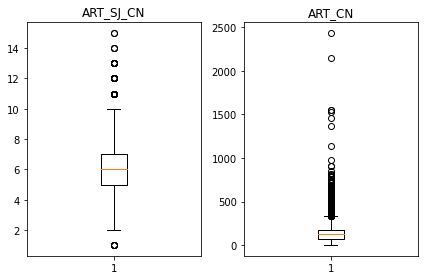

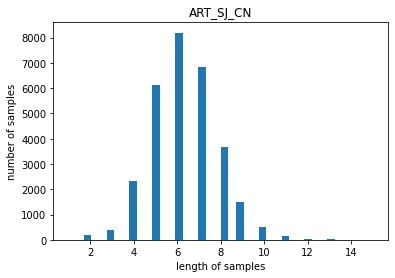

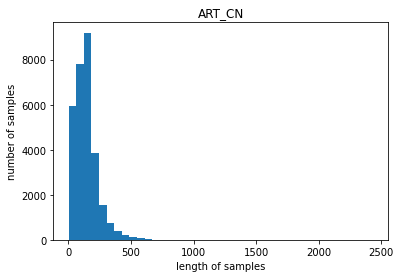

In [17]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['ART_CN']]
summary_len = [len(s.split()) for s in data['ART_SJ_CN']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('ART_SJ_CN')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('ART_CN')
plt.tight_layout()
plt.show()

plt.title('ART_SJ_CN')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('ART_CN')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
text_max_len = 150
summary_max_len = 8

In [19]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['ART_CN'])

전체 샘플 중 길이가 150 이하인 샘플의 비율: 0.6084109964258275


In [21]:
below_threshold_len(summary_max_len, data['ART_SJ_CN'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9269131843538096


In [22]:
data = data[data['ART_CN'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['ART_SJ_CN'].apply(lambda x: len(x.split()) <= summary_max_len)]
print("전체 샘플 수 :", (len(data)))

전체 샘플 수 : 17266


In [23]:
data.head()

,ART_SJ_CN,ART_CN
4,"중기부, 전통시장에 화재알림시설 설치",앞으로 5년내 전국 전통시장에 첨단 IT 기반의 화재알림시설이 설치된다. 홍종학 중...
5,연기 나자마자 감지…'제2의 소래포구 참사' 막는다,"앵커멘트 대구 서문시장, 여수 수산시장, 인천 서래포구 지난 겨울 전통시장에서 화재..."
6,[뉴스 8] 장의 사진,뉴스 8이 선정한 장의 사진입니다. 서울 문정동 아파트에서 경비원이 종이 가루를 쓸...
8,"[뉴스8 단신] 작년 수출 5,739억 달러 '사상 최대'","지난해 우리나라의 연간 수출액이 5천739억 달러로, 1년 전보다 16%나 증가하며..."
9,"최저임금 시간당 7,530원…병원비 부담 감소","앵커멘트 올해부터 최저임금이 시간당 7천530원으로 오르고, 저소득층의 병원비 부담..."


In [24]:
data['decoder_input'] = data['ART_SJ_CN'].apply(lambda x : 'sostoken ' + x)
data['decoder_target'] = data['ART_SJ_CN'].apply(lambda x : x + ' eostoken')
data.head()

,ART_SJ_CN,ART_CN,decoder_input,decoder_target
4,"중기부, 전통시장에 화재알림시설 설치",앞으로 5년내 전국 전통시장에 첨단 IT 기반의 화재알림시설이 설치된다. 홍종학 중...,"sostoken 중기부, 전통시장에 화재알림시설 설치","중기부, 전통시장에 화재알림시설 설치 eostoken"
5,연기 나자마자 감지…'제2의 소래포구 참사' 막는다,"앵커멘트 대구 서문시장, 여수 수산시장, 인천 서래포구 지난 겨울 전통시장에서 화재...",sostoken 연기 나자마자 감지…'제2의 소래포구 참사' 막는다,연기 나자마자 감지…'제2의 소래포구 참사' 막는다 eostoken
6,[뉴스 8] 장의 사진,뉴스 8이 선정한 장의 사진입니다. 서울 문정동 아파트에서 경비원이 종이 가루를 쓸...,sostoken [뉴스 8] 장의 사진,[뉴스 8] 장의 사진 eostoken
8,"[뉴스8 단신] 작년 수출 5,739억 달러 '사상 최대'","지난해 우리나라의 연간 수출액이 5천739억 달러로, 1년 전보다 16%나 증가하며...","sostoken [뉴스8 단신] 작년 수출 5,739억 달러 '사상 최대'","[뉴스8 단신] 작년 수출 5,739억 달러 '사상 최대' eostoken"
9,"최저임금 시간당 7,530원…병원비 부담 감소","앵커멘트 올해부터 최저임금이 시간당 7천530원으로 오르고, 저소득층의 병원비 부담...","sostoken 최저임금 시간당 7,530원…병원비 부담 감소","최저임금 시간당 7,530원…병원비 부담 감소 eostoken"


In [25]:
encoder_input = np.array(data['ART_CN'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[16825  2288 12300 ...   922 12088 11160]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 3453


In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [30]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 13813
훈련 레이블의 개수 : 13813
테스트 데이터의 개수 : 3453
테스트 레이블의 개수 : 3453


In [31]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [32]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 240602
등장 빈도가 6번 이하인 희귀 단어의 수: 217340
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23262
단어 집합에서 희귀 단어의 비율: 90.33175119076317
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 28.002168908476317


In [33]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [34]:
print(encoder_input_train[:3])

[[15, 2352, 1780, 764, 1676, 600, 86, 1018, 1086, 2093, 186, 176, 216, 269, 3258, 72, 414, 229, 2093, 2949, 60, 60, 59, 392, 486, 7771, 1940, 6760, 269, 3098, 60, 1338, 394, 303, 935, 4232, 3878, 14, 131, 764, 439, 1406, 34, 1, 32, 33, 31], [3259, 69, 714, 386, 446, 3259, 688, 2307, 347, 2530, 30, 20, 849, 170, 639, 58, 65, 38, 1561, 15, 251, 520, 46, 61, 1087, 1204, 69, 65, 6186, 1803, 173, 458, 38, 126, 460, 251, 849, 46, 150, 69, 1204, 1294, 208, 849, 70, 1087, 95, 92, 15, 116, 92, 217, 61, 7081, 4365, 2265, 1278, 12, 3505, 7082, 16, 170, 5139, 1204, 116, 535, 6187, 150, 208, 5140, 7772, 13, 7, 6, 4, 3, 2, 8, 9, 5], [702, 2950, 210, 2266, 1250, 568, 452, 387, 2094, 327, 2405, 1392, 3425, 298, 1589, 1536, 25, 3506, 1804]]


In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [36]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31173
등장 빈도가 5번 이하인 희귀 단어의 수: 28996
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2177
단어 집합에서 희귀 단어의 비율: 93.01639239085105
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 42.236524537409494


In [37]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [38]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [39]:
print(decoder_input_train[:5])

[[1, 1378, 128, 530, 65, 8], [1, 849, 531, 222], [1, 208, 452], [1, 143, 32, 11], [1, 36, 509, 196]]


In [40]:
print(decoder_target_train[:5])

[[1378, 128, 530, 65, 8, 2], [849, 531, 222, 2], [208, 452, 2], [143, 32, 11, 2], [36, 509, 196, 2]]


In [41]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [42]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 469
삭제할 테스트 데이터의 개수 : 129


In [43]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 13344
훈련 레이블의 개수 : 13344
테스트 데이터의 개수 : 3324
테스트 레이블의 개수 : 3324


In [44]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

In [45]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [46]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [47]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [48]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 128)     1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 150, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [49]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [50]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 128)     1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 150, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [51]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, 
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
 1/53 [..............................] - ETA: 0s - loss: 7.6031

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [ ]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [ ]:
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 =decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]
        
        if(sampled_token!='eostoken'):
            decoded_sentence += ' ' + sampled_token
            
        if(sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True
            
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        e_h, e_c = h, c
    
    return decoded_sentence

In [ ]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(500, 1000):
    print("원문 : ", seq2text(encoder_input_test[i]))
    print("실제 요약문 :", seq2summary(decoder_input_test[i]))
    print("예측 요약문 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")